In [9]:
import cv2
from matplotlib import pyplot as plt

In [10]:
filename = '0X100009310A3BD7FC.avi'
frame_number = 46

In [11]:
import pandas as pd

# Extract volume tracing (make sure to unzip file)
# tracePath = f'EchoNet-Dynamic/EchoNet-Dynamic/VolumeTracings.csv'
tracePath = f'VolumeTracings.csv'
# Read the CSV file
dfTrace = pd.read_csv(tracePath)

# print(dfTrace.columns)

# Filter the DataFrame based on conditions
dfPoints = dfTrace[(dfTrace['FileName'] == filename) & (dfTrace['Frame'] == frame_number)]
dfPoints = dfPoints[['X1', 'Y1', 'X2', 'Y2']]
print(dfPoints)


           X1         Y1         X2         Y2
0   51.260417  15.348958  64.932292  69.125000
1   50.037611  17.167841  53.367222  16.321330
2   49.157378  20.407629  57.090549  18.390722
3   48.538173  23.581055  59.997339  20.667707
4   47.918968  26.754480  62.904129  22.944693
5   47.962105  29.759513  65.810920  25.221679
6   48.167915  32.723188  68.247043  27.618326
7   48.373726  35.686864  70.385311  30.090698
8   48.579537  38.650539  72.523579  32.563071
9   49.014039  41.556073  74.151644  35.165156
10  49.830999  44.364371  75.712998  37.784202
11  50.647959  47.172670  77.274352  40.403248
12  51.464918  49.980968  78.644694  43.070856
13  52.547328  52.721780  79.485375  45.873124
14  53.704269  55.443642  80.326055  48.675392
15  54.365630  58.291500  80.609375  51.619361
16  51.151352  62.124689  80.609375  54.635361
17  49.336719  65.602037  80.431214  57.696657
18  50.348287  68.360859  80.065451  60.805648
19  57.512976  69.555328  79.699687  63.914639
20  71.938353

Video/0X100009310A3BD7FC.avi


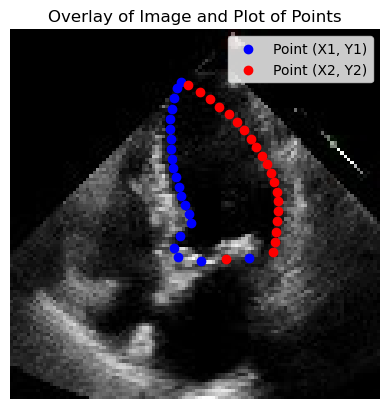

In [12]:
#Extracting Frames test
import cv2
import matplotlib.pyplot as plt

# Extract the frame from the video

# video_path = f'EchoNet-Dynamic/EchoNet-Dynamic/Videos/{filename}'

video_path = f'Video/{filename}'
print(video_path)

# Open the video
video = cv2.VideoCapture(video_path)

# Desired frame number

video.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

# Read the frame
ret, frame = video.read()
img = ''
if ret:
  
    # Save the frame as an image
    cv2.imwrite('extracted_frame.jpg', frame)
    img = cv2.imread('extracted_frame.jpg')    
    # Convert from BGR to RGB (OpenCV uses BGR by default)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.cla()
    # Display the image with points overlaid
    plt.imshow(img)
    plt.axis('off')  # Turn off axis
    
    # Plot X1, Y1 and X2, Y2 on top of the image
    plt.scatter(dfPoints['X1'], dfPoints['Y1'], color='blue', label='Point (X1, Y1)')
    plt.scatter(dfPoints['X2'], dfPoints['Y2'], color='red', label='Point (X2, Y2)')
    
    # Optionally, add labels, title, and legend
    plt.xlabel('X1')
    plt.ylabel('Y1')
    plt.title('Overlay of Image and Plot of Points')
    plt.legend()

    # Invert the y-axis to match the image coordinates (not needed with imshow)
#     plt.gca().invert_yaxis()

    # Show the plot
    plt.show()

else:
    print("Failed to extract frame")

# Release the video capture object
video.release()


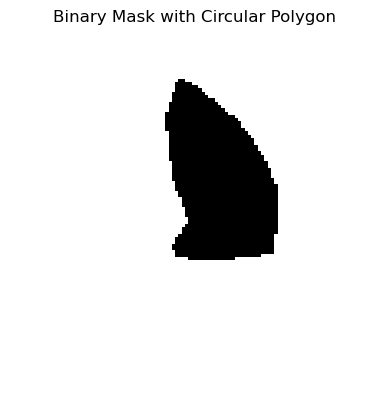

In [13]:
#Generating Mask test

import numpy as np
import cv2
import matplotlib.pyplot as plt

# Function to compute the Euclidean distance between two points
def euclidean_distance(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

# Function to create a circular polygon by selecting nearest neighbors (circular mask)
def create_nearest_polygon(points):
    # Start with the first point
    polygon = [points[0]]
    remaining_points = points[1:].copy()  # Copy of the remaining points

    current_point = points[0]

    while len(remaining_points) > 0:
        # Calculate distances from the current point to all remaining points
        distances = [euclidean_distance(current_point, p) for p in remaining_points]
        nearest_idx = np.argmin(distances)  # Index of the nearest point
        
        # Add the nearest point to the polygon
        nearest_point = remaining_points[nearest_idx]
        polygon.append(nearest_point)
        
        # Update the current point and remove it from remaining points
        current_point = nearest_point
        remaining_points = np.delete(remaining_points, nearest_idx, axis=0)

    # Close the polygon by adding the first point at the end
    polygon.append(polygon[0])

    return np.array(polygon)

# Function to generate a binary mask from points
def generate_mask_from_points(points, img_shape):
    
    # Create the polygon by selecting the nearest point 
    sorted_points = create_nearest_polygon(points)

    # Create a blank white mask (same size as the image)
    mask = np.ones(img_shape, dtype=np.uint8) * 255

    # Reshape for OpenCV (N, 1, 2)
    sorted_points = sorted_points.reshape((-1, 1, 2))

    # Fill the polygon with black
    cv2.fillPoly(mask, [sorted_points], color=(0, 0, 0))

    return mask

# Test :
points = np.vstack([
    dfPoints[['X1', 'Y1']].values,
    dfPoints[['X2', 'Y2']].values
]).astype(np.int32)

# Set the image shape (height, width) – use the shape of your image
img_shape = img.shape[:2]  # (height, width)

# Generate the mask
mask = generate_mask_from_points(points, img_shape)

# Display the mask
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.title("Binary Mask with Circular Polygon")
plt.show()


In [14]:
import numpy as np
import cv2

# Function to save a mask as an image with transparency (RGBA)

def save_mask_with_transparency(mask, path):
    
    # Ensure the mask is in the correct format (uint8)
    if mask.dtype != np.uint8:
        mask = mask.astype(np.uint8)
    
    # Create an RGBA image (4 channels: Red, Green, Blue, Alpha)
    rgba_mask = np.zeros((mask.shape[0], mask.shape[1], 4), dtype=np.uint8)

    # Set RGB channels to white (255, 255, 255)
    rgba_mask[:, :, :3] = 255  # Red, Green, Blue channels set to 255 (white)
    
    # Set alpha channel: 255 for the mask, 0 for the transparent background
    rgba_mask[mask == 0] = (255, 255, 255, 0)  # Background (white) becomes transparent
    rgba_mask[mask == 255] = (0, 0, 0, 255)   # Mask (black) becomes opaque (alpha = 255)

    # Save the RGBA mask as an image with transparency (PNG format)
    cv2.imwrite(path, rgba_mask)

    print(f"Mask saved with transparency to {path}")

# save_mask_with_transparency(mask,'./EchoNet-Dynamic/EchoNet-Dynamic/labels_alt/maskimagetest3.png')



# Function to save the frame image (as PNG)
def save_frame_as_image(frame, path):
    # Convert frame to RG, OpenCV uses BGR by default
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Save the image
    cv2.imwrite(path, rgb_frame)
    print(f"Frame saved to {path}")


In [15]:
# Frame Extraction Implementation
import numpy as np
import cv2
import pandas as pd
import os


# keep track of processed (FileName, Frame) combinations
processed_combinations = set()

# Process the DataFrame
for index, row in  dfTrace.iterrows(): #contains the  files from FileList.csv
    filename = row['FileName']
    frame_number = row['Frame']

    # Check already processed
    if (filename, frame_number) in processed_combinations:
#         print(f"Skipping already processed {filename} frame {frame_number}")
        continue

    # mark this combination as processed
    processed_combinations.add((filename, frame_number))
    
    dfPoints = dfTrace[(dfTrace['FileName'] == filename) & (dfTrace['Frame'] == frame_number)]
    dfPoints = dfPoints[['X1', 'Y1', 'X2', 'Y2']]

  
    #     video_path = f'EchoNet-Dynamic/EchoNet-Dynamic/Videos/{filename}'
    video_path = f'./Videos/{filename}'
    
    video = cv2.VideoCapture(video_path)

    # Set the frame position
    video.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

    # Read the frame
    ret, frame = video.read()

    if ret:
        # Extract the points for that frame (X1, Y1, X2, Y2)
        points = np.vstack([  # Stack points (X1, Y1) and (X2, Y2)
            dfPoints[['X1', 'Y1']].values,
            dfPoints[['X2', 'Y2']].values
        ]).astype(np.int32)
        
    
        img_shape = frame.shape[:2]  # (height, width)

        # Generate the mask from the points(with the same shape)
        mask = generate_mask_from_points(points, img_shape)

        # Specify the save path for the mask (ensure directory is available and file is a PNG for transparency)
        # save_path = f'./EchoNet-Dynamic/EchoNet-Dynamic/labels_alt/{filename}_mask_{frame_number}.png'
        save_path = f'masks/{filename}_mask_{frame_number}.png' # make sure path exists

        # Save the mask with transparency
        save_mask_with_transparency(mask, save_path)
    else:
        print(f"Failed to read frame {frame_number} from {filename}")
    
    # Release the video capture object
    video.release()


Mask saved with transparency to masks/0X100009310A3BD7FC.avi_mask_46.png
Mask saved with transparency to masks/0X100009310A3BD7FC.avi_mask_61.png
Mask saved with transparency to masks/0X1002E8FBACD08477.avi_mask_3.png
Mask saved with transparency to masks/0X1002E8FBACD08477.avi_mask_18.png
Mask saved with transparency to masks/0X1005D03EED19C65B.avi_mask_24.png


In [16]:
import numpy as np
import cv2
import pandas as pd
import os

# Set to keep track of processed (FileName, Frame) combinations
processed_combinations = set()

# Process the DataFrame
for index, row in  dfTrace.iterrows():
    filename = row['FileName']
    frame_number = row['Frame']

    # Check if this (FileName, Frame) combination has already been processed
    if (filename, frame_number) in processed_combinations:
#         print(f"Skipping already processed {filename} frame {frame_number}")
        continue

    # Mark this combination as processed
    processed_combinations.add((filename, frame_number))
    
    dfPoints = dfTrace[(dfTrace['FileName'] == filename) & (dfTrace['Frame'] == frame_number)]
    dfPoints = dfPoints[['X1', 'Y1', 'X2', 'Y2']]

    # Construct the video path
    #     video_path = f'EchoNet-Dynamic/EchoNet-Dynamic/Videos/{filename}'
    video_path = f'./Videos/{filename}'
    # Open the video
    video = cv2.VideoCapture(video_path)

    # Set the frame position
    video.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

    # Read the frame
    ret, frame = video.read()

    if ret:
        save_path = f'./images/{filename}_img_{frame_number}.png'

        # Save the mask with transparency
        save_frame_as_image(frame, save_path)
    else:
        print(f"Failed to read frame {frame_number} from {filename}")
    
    # Release the video capture object
    video.release()


Frame saved to ./images/0X100009310A3BD7FC.avi_img_46.png
Frame saved to ./images/0X100009310A3BD7FC.avi_img_61.png
Frame saved to ./images/0X1002E8FBACD08477.avi_img_3.png
Frame saved to ./images/0X1002E8FBACD08477.avi_img_18.png
Frame saved to ./images/0X1005D03EED19C65B.avi_img_24.png
